# Demo: Control of a reaction wheel

Import modules and configure the notebook.

In [2]:
# These are standard modules
import time
import numpy as np
import matplotlib.pyplot as plt

# This is a custom interface to the pybullet simulator
import ae353_wheel

pybullet build time: Jan 28 2022 20:18:15


Create an instance of the `Simulator` class, which is an interface to the [pybullet](http://pybullet.org) simulation engine.

There are two optional arguments:

* `display` (`True` or `False`) is whether or not to show the simulation window;
* `damping` (a non-negative floating-point number) is the coefficient of viscous friction at the wheel joint.

**You must evaluate this cell only *once*.** If you want to start fresh with a new simulator, you must do `Kernel -> Restart` from the notebook menu first. If you evaluate this cell more than once without a call to `Kernel -> Restart` then you may get strange behavior that is hard to debug.

In [3]:
simulator = ae353_wheel.Simulator(
    display=False,
    damping=0.5,
)

Define a controller that maps sensor measurements (`wheel_angle` and `wheel_velocity`) to actuator commands (`wheel_torque`). By default, it chooses to apply zero torque to the wheel. Modify the `run` function to make the controller behave differently.

In [179]:
class Controller:
    def __init__(self):
        self.angle_des = 0
    
    def reset(self):
        self.error_accumulator = 0
        self.error_diff = 0
        self.prev_error = 0
        self.lastTime = -.006
        self.variables_to_log = ['angle_des', 'w']
    
    def run(self, t, wheel_angle, wheel_velocity):
        """
        INPUTS
         t = current time (s)
         wheel_angle = angle of wheel (rad)
         wheel_velocity = angular velocity of wheel (rad/s)
        
        OUTPUTS
         wheel_torque = torque applied to wheel by motor on ground (N m)
        """
        
        # FIXME: replace the following line

        self.w = t/1000
        self.angle_des = np.sin(self.w * t)

        error = self.angle_des - wheel_angle

        self.error_accumulator += error

        self.error_dt = (error - self.prev_error) / (t - self.lastTime)

        self.prev_error = error
        self.lastTime = t

        Kp = 0.5
        Ki = .01
        # Ki = 0.0001
        Kd = 0.08

        wheel_torque = Kp * error + Ki * self.error_accumulator + Kd * self.error_dt
        
        return wheel_torque

Create an instance of the controller.

In [180]:
controller = Controller()

Reset the simulator. Optional arguments allow you to specify the initial wheel angle and velocity. If the value of either argument is `None` (or if the argument is left unspecified), then its value will be chosen at random.

In [181]:
simulator.reset(
    wheel_angle=None,
    wheel_velocity=None
)

Reset the controller.

In [182]:
controller.reset()

Choose a camera view (could be `simulator.camera_topview()` or `simulator.camera_sideview()`).

In [183]:
simulator.camera_topview()

Run the simulator.

In [184]:
data = simulator.run(
    controller,           # <-- required (an instance of your Controller class)
    max_time=10000.0,         # <-- optional (how long you want to run the simulation in seconds)
    data_filename=None,   # <-- optional (name of file to which you want data saved, e.g., 'my_data.json')
    video_filename=None,  # <-- optional (name of file to which you want video saved, e.g., 'my_video.mov')
)

Simulated 1000000 time steps in 56.8021 seconds (17604.9832 time steps per second)


Get, show, and save a snapshot of the simulation after the last time step.

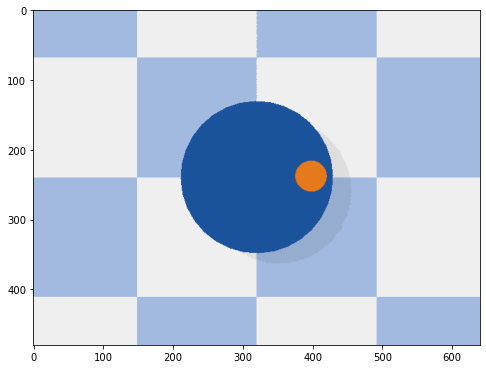

In [185]:
# Get snapshot as height x width x 4 numpy array of RGBA values
rgba = simulator.snapshot()

# Display snapshot
plt.figure(figsize=(8, 8))
plt.imshow(rgba)

# Save snapshot
plt.imsave('my_snapshot.png', rgba)

Plot the results.

/var/folders/84/3j3h65z55vs1f4cfjg8vd24r0000gn/T/ipykernel_8755/3996758550.py:52: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.tight_layout()
/Users/parth/opt/anaconda3/envs/ae353/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


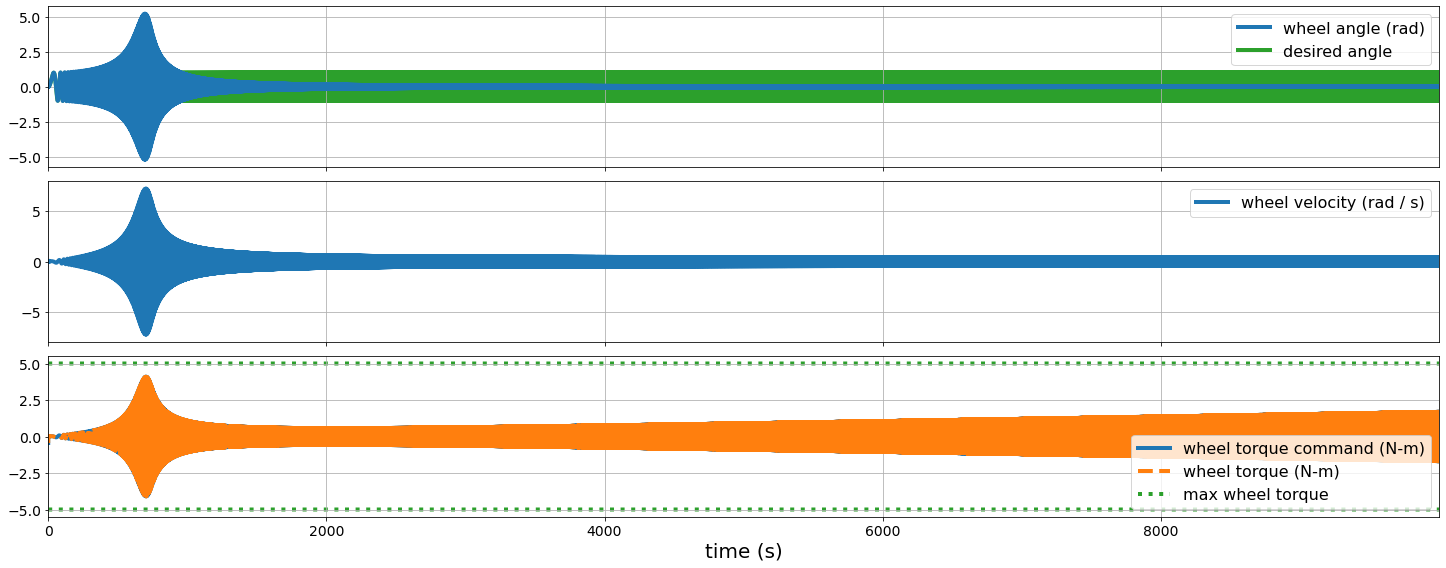

In [186]:
# Create a figure with three subplots, all of which share the same x-axis
fig, (ax_angle, ax_velocity, ax_torque) = plt.subplots(3, 1, figsize=(20, 8), sharex=True)

# Plot wheel angle on first subplot
ax_angle.plot(
    data['t'], data['wheel_angle'],
    label='wheel angle (rad)', linewidth=4,
)
ax_angle.plot(
    data['t'], data['angle_des'], '-', label='desired angle', linewidth=4, color='C2', zorder=0,
)
ax_angle.grid()
ax_angle.legend(fontsize=16)
ax_angle.tick_params(labelsize=14)

# Plot wheel velocity on second subplot
ax_velocity.plot(
    data['t'], data['wheel_velocity'],
    label='wheel velocity (rad / s)', linewidth=4,
)
ax_velocity.grid()
ax_velocity.legend(fontsize=16)
ax_velocity.tick_params(labelsize=14)

# Plot wheel torque on third subplot
ax_torque.plot(
    data['t'], data['wheel_torque_command'],
    label='wheel torque command (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['wheel_torque'],
    '--', label='wheel torque (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], np.ones_like(data['t']) * simulator.tau_max,
    ':', label='max wheel torque', linewidth=4, color='C2', zorder=0,
)
ax_torque.plot(
    data['t'], -np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C2', zorder=0,
)
ax_torque.grid()
ax_torque.legend(fontsize=16)
ax_torque.tick_params(labelsize=14)

# Set x-axis properties (only need to do this on the third
# subplot since all three subplots share the same x-axis)
ax_torque.set_xlabel('time (s)', fontsize=20)
ax_torque.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()

Save the figure (without transparent background).

In [187]:
fig.savefig('my_figure.png', facecolor='white', transparent=False)

/var/folders/84/3j3h65z55vs1f4cfjg8vd24r0000gn/T/ipykernel_8755/3828734517.py:1: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig('my_figure.png', facecolor='white', transparent=False)


/Users/parth/opt/anaconda3/envs/ae353/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


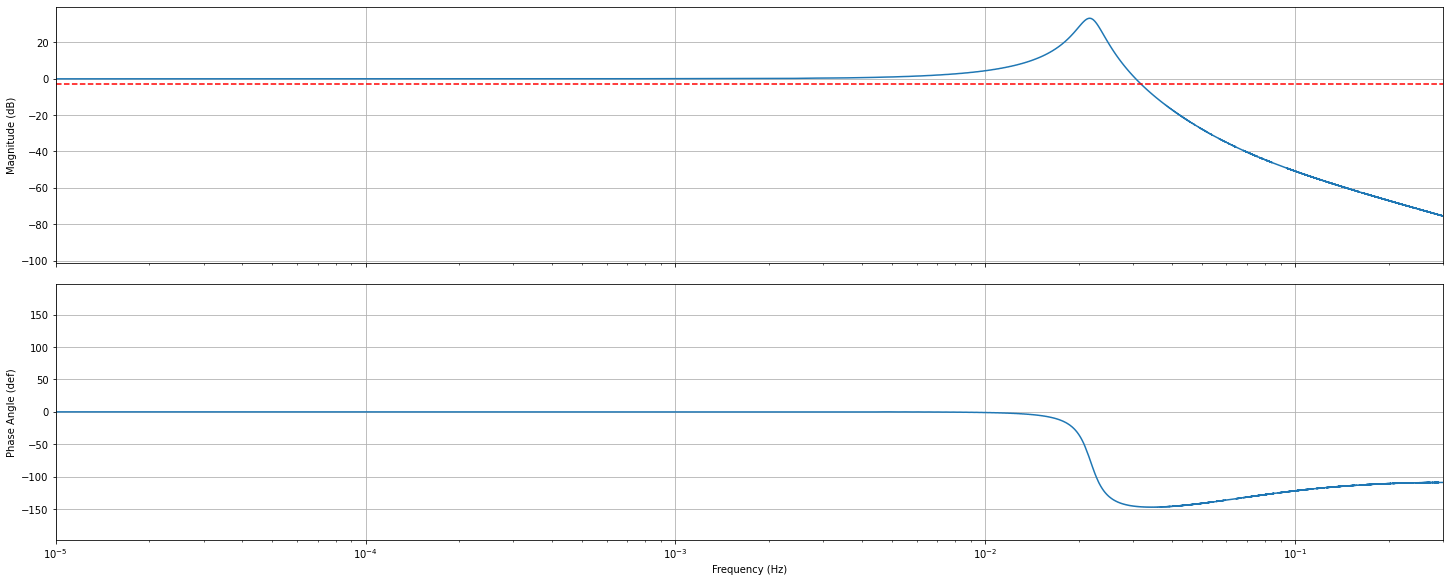

In [188]:
input = data['angle_des']
output = data['wheel_angle']
 
inputfft = np.fft.fft(input)
outputfft = np.fft.fft(output)

dt = data['t'][1] - data['t'][0]
T = data['t'].max() + dt
df = 1.0/T

freq = data['w']

dbMag = 20*np.log(outputfft/inputfft)
phaseAngle = np.rad2deg(np.angle(outputfft/inputfft))

fig, (ax_mag, ax_angle) = plt.subplots(2, 1, figsize=(20, 8), sharex=True)
fig.tight_layout()
ax_mag.semilogx(freq, dbMag)
ax_mag.set_ylabel('Magnitude (dB)')
ax_mag.axhline(-3 ,color="red", linestyle="--")
ax_mag.grid()
ax_mag.set_xlim(1e-5, 3e-1)
ax_angle.semilogx(freq, phaseAngle)
ax_angle.set_ylabel("Phase Angle (def)")
ax_angle.set_xlabel("Frequency (Hz)")
ax_angle.grid()
